In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import seaborn as sb
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from numba import vectorize
import unidecode
from nltk.corpus import stopwords
import time
import spacy

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Normalizer



import string,lxml,bs4,nltk
from warnings import simplefilter

# 0- Functions & Definitions

#### Variables

In [2]:
contractions = {
"ain't": "are not",
"aren't": "am not",
"can't": "can not",
"can't've": "can not have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"i'd": "I had",
"i'd've": "I would have",
"i'll": "I will",
"i'll've": "I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that had",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they had",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

#### Function: to load file

In [3]:
#This function will load file and return it as Data Frame and also return list of column names
def loadFile(fileName):
    #reading the temp file to a dataframe with the new headers    
    print('Loading File...',end='')
    result = pd.read_csv(fileName)
    print('[ok]')
    print('Loaded {:,} reviews' .format(len(result)))    
    print('Column Names: ', result.columns.tolist())
    return result, result.columns.tolist()

#### Function: to drop unused columns

In [4]:
#This fuction will return modified dataframe with selected columns only
def neededColumnsOnly(df, columns_needed):
    #return df.filter(columns_needed) 
    #Or
    to_drop_columns = list(x for x in df.columns.tolist() if x not in columns_needed)
    df.drop(to_drop_columns,axis=1,inplace=True)
    return df

#### Function: to find columns containing nulls

In [5]:
#This fuction will check which columns having null values
def columns_with_nulls(df, index_column):
    null_columns = []
    for column in df.columns:
        if column != index_column:
            check_null = df.isnull()[[column,index_column]].groupby(column).agg('count')
            try:
                if check_null.loc[True][0] > 0:
                    null_columns.append(column)
            except:
                pass
    return null_columns

#### Function: to remove all null values from columns

In [6]:
#This fuction will remove all nulls in columns found earlier
def remove_nulls(df, columns):
    for column in columns:
        df[column].fillna('', inplace=True)
    return df

#### Function: to find columns containing html tags

In [7]:
#This fuction will check which columns having html tags
def columns_with_html(df):
    null_columns = []
    for column in df.columns:
        try:
            text_html = df[column].str.find('<')
            text_html = text_html[text_html != -1]
            check_null = len(text_html)
            if check_null > 0:
                null_columns.append(column)
        except:
            pass
    return null_columns

#### Function: to remove html tags from data

In [8]:
#This fuction will remove all html tags in text
def remove_html_tags(text):
    sp = BeautifulSoup(text, "html.parser")
    returned_text = sp.get_text(separator=" ")
    return returned_text

#### Function: to merge Summary and Text in one column and get rid of productId column

In [9]:
#This fuction will result in two columns only score and review
def merge_summary_text(df):
    df['review']=df['Summary']+' '+df['Text'] 
    df.drop(['Summary','Text','ProductId'],axis=1,inplace=True)
    return df

#### Function: to correct accent in letters

In [10]:
#This function will replace accents in letters with regular letters example nescafé will be nescafe
def correct_accent(text):
    returned_text = unidecode.unidecode(text)
    return returned_text

#### Function: to visualized score count

In [11]:
def visualize_score_count(df):
    # visualize total review by score count
    final_df_grouped = df[['Score', 'review']].groupby('Score').agg('count')
    final_df_grouped= final_df_grouped.reset_index()
    f, ax = plt.subplots(figsize=(8, 6))
    fig = sb.barplot(x='Score', y="review", data=final_df_grouped)

#### Function: to remove punctuations

In [12]:
#This function will remove punctiatons
def remove_punctuations(text):
    for punc in string.punctuation.replace("'",""):
        if punc in text:
            text = text.replace(punc," ")
    return text

#### Function: to remove extra spaces

In [13]:
#This function will remove extra spaces
def remove_extra_space(text):
    removed_space = " ".join(text.split())
    return removed_space

#### Function: to expand short words

In [14]:
#This function will expand short words such as isn't => is not
def expand_words(text):
    for word in text.split():
        if word.lower() in contractions:
            text = text.replace(word, contractions[word.lower()])
    return text

#### Function: to replace remaining punctuation '

In [15]:
#This function will remove '
def remove_apostrophe(text):
    text = text.replace("'", " ")
    return text

#### Function: to remove english stop words

In [16]:
# we will remove stop words except no and not since they will effect our classification
def remove_stop_words(text):
    sWords = set(stopwords.words('english'))
    sWords = list(sWords)
    deselect_stop_words = ['no', 'not']

    for item in deselect_stop_words:
        sWords.remove(item)
    for word in sWords:
        text = text.replace(" " + word.lower() + " "," ")
    return text

#### Function: to transform all to lower case

In [17]:
def toLower(text):
    text = text.lower()
    return text

#### Function: to tokenize text

In [18]:
def tokeniz(text):
    return word_tokenize(text)

#### Function: to stemm text

In [19]:
def stemm(text):
    stemmer = PorterStemmer()
    stemmed = [stemmer.stem(word) for word in text.split()]
    stemmed = ' '.join(stemmed) 
    return stemmed

#### Function: to lemmetize text

In [20]:
def lemm(text):
    lemmatizer = WordNetLemmatizer()
    lemmed = [lemmatizer.lemmatize(word) for word in text.split()]
    lemmed = ' '.join(lemmed) 
    return lemmed

#### Function: to lemm text using Spacy

In [107]:
def spacy_lemm(text):
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    doc = nlp(text)
    lemmed = [token.lemma_ for token in doc]
    lemmed = ' '.join(lemmed) 
    return lemmed

#### Function: to Represent Vector Count Model

In [22]:
# this fuction will take the type of model (CountVector or TFIDF) and will return train data, feature name and vector repr. matrix

def VCM (vectorizer,df, colum_name, class_column, ngram_min = 1, ngram_max = 1):
    if vectorizer == "count":
        vect = CountVectorizer(ngram_range=(ngram_min,ngram_max)).fit(df[colum_name])
    elif vectorizer == "tfidf":
        vect = TfidfVectorizer(ngram_range=(ngram_min,ngram_max)).fit(df[colum_name])
    
    x_Train = vect.transform(df[colum_name])
    y_Train = df[class_column]
    feature_names = vect.get_feature_names()
    dense_vect = x_Train.todense()
    dense_list = dense_vect.tolist()
    vectDF = pd.DataFrame(dense_list, columns=feature_names)
    return x_Train, y_Train, vect, feature_names, vectDF

# 1-Data Exploration and Visualization: (10%)
Provide an initial step to inspect, visualize and analyse the different attributes in your data set.
Document your findings and make conclusions for your next steps.


## Data loading and visualization

####  Load Data File

In [23]:
# Load Data Set, this will return our main Data set and list of column names

original_df, column_names = loadFile('train.csv')

Loading File...[ok]
Loaded 426,340 reviews
Column Names:  ['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text']


####   Data Discovery

In [24]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426340 entries, 0 to 426339
Data columns (total 10 columns):
Id                        426340 non-null int64
ProductId                 426340 non-null object
UserId                    426340 non-null object
ProfileName               426326 non-null object
HelpfulnessNumerator      426340 non-null int64
HelpfulnessDenominator    426340 non-null int64
Score                     426340 non-null int64
Time                      426340 non-null int64
Summary                   426320 non-null object
Text                      426340 non-null object
dtypes: int64(5), object(5)
memory usage: 32.5+ MB


In [25]:
# describing the original dataframe
original_df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,426340.000000,426340.000000,426340.000000,426340.000000,4.263400e+05
mean,284300.799618,1.733159,2.220244,4.183455,1.296222e+09
std,164012.600602,7.328184,8.014894,1.310577,4.808061e+07
min,1.000000,0.000000,0.000000,1.000000,9.408096e+08
25%,142363.750000,0.000000,0.000000,4.000000,1.271203e+09
50%,284308.500000,0.000000,1.000000,5.000000,1.311034e+09
75%,426183.250000,2.000000,2.000000,5.000000,1.332720e+09
max,568454.000000,844.000000,923.000000,5.000000,1.351210e+09


#### Data Visualization

C:\Users\tamers\AppData\Local\Continuum\anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002852091A448>,
      dtype=object)

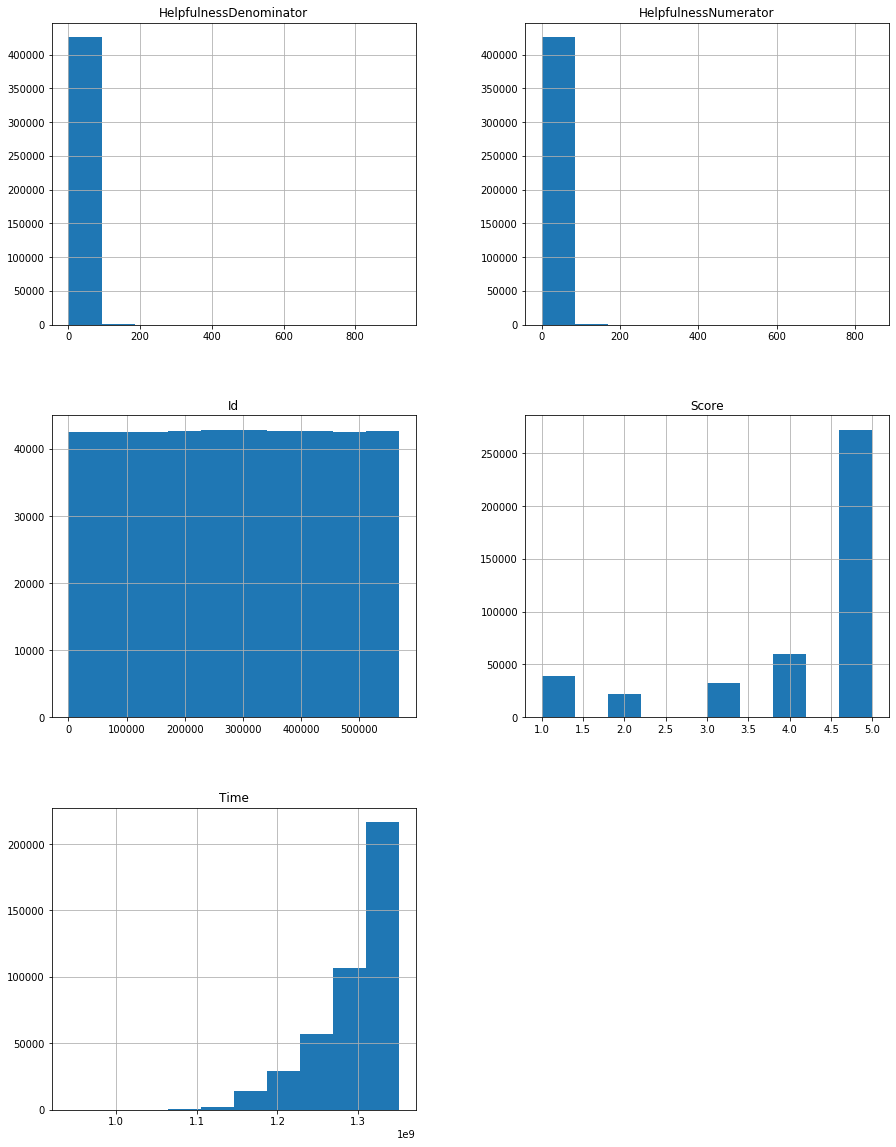

In [26]:
# Visualize original original data
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
original_df.hist(bins=10, ax=ax)

In [27]:
#checking for null values
original_df.isnull().values.any()

True

In [28]:
#checking the total number of null values
original_df.isna().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               14
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   20
Text                       0
dtype: int64

In [98]:
#Groupby by score
original_df.groupby('Score').describe()

ProductId                         Summary                              \
          count unique         top freq   count  unique           top  freq   
Score                                                                         
1         39193  16944  B000X1Q1G8  101   39193   23736  Disappointed   183   
2         22353  11372  B000KV7ZGQ   60   22353   14306  Disappointed   200   
3         31993  13798  B006MONQMC  102   31993   20925       Just OK    97   
4         60309  21073  B007JFMH8M  166   60309   37582     Delicious   182   
5        272492  53399  B007JFMH8M  444  272492  146378    Delicious!  1668   

         Text                                                                  
        count  unique                                                top freq  
Score                                                                          
1       39193   28385  This review will make me sound really stupid, ...  140  
2       22353   16265  I had hoped this tea would taste better but it...   23  
3       31993   23248  Not enough flavor, murky brown color, lacking ...   22  
4       60309   43792  Stash Chamomile Herbal Tea is tea bags with dr...   31  
5      272492  196618  Diamond Almonds<br />Almonds are a good source...   94

In [30]:
# re-arranging columns to make the class column the last one
original_df = original_df[['Id','ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Summary', 'Text', 'Score']]

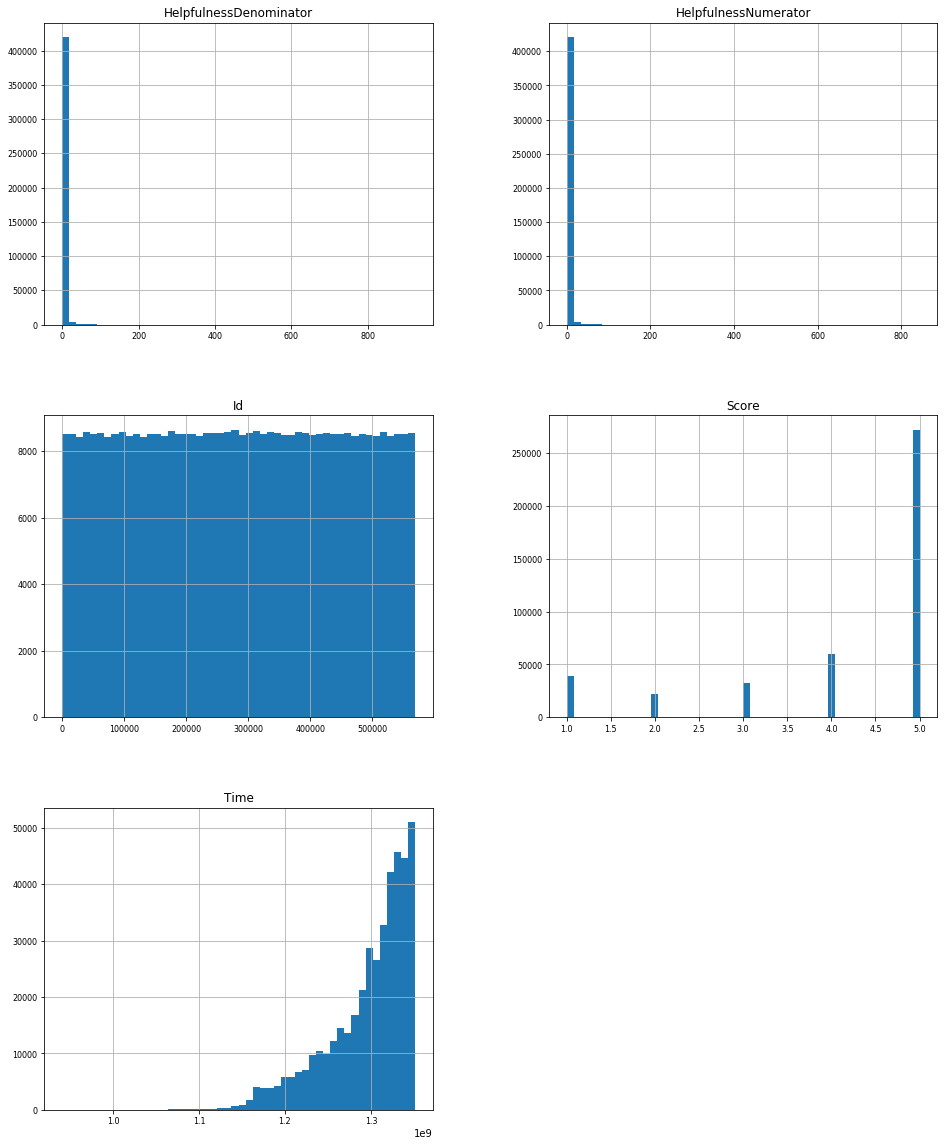

In [31]:
df_num = original_df.select_dtypes(include = ['float64', 'int64'])
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

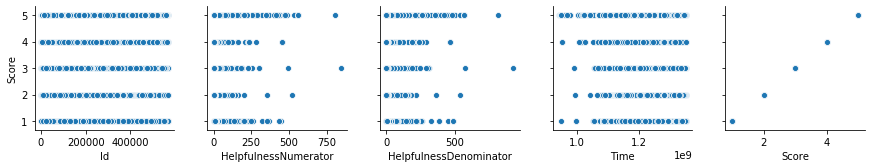

In [32]:
for i in range(0, len(df_num.columns), 5):
    sns.pairplot(data=df_num,
                x_vars=df_num.columns[i:i+5],
                y_vars=['Score'])

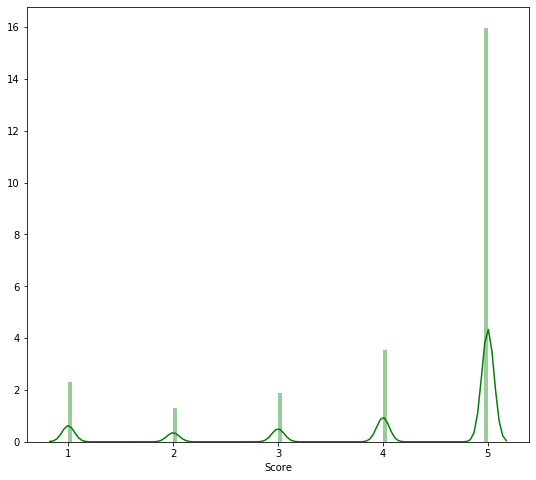

In [33]:
plt.figure(figsize=(9, 8))
sns.distplot(original_df['Score'], color='g', bins=100, hist_kws={'alpha': 0.4});

In [34]:
import operator

# here we calculate the correlations of all of our numeric attributes. we ignore attributes with correlation of 0.
individual_features_df = []
for i in range(0, len(df_num.columns) - 1): # -1 because last column is score.
    tmpDf = df_num[[df_num.columns[i], 'Score']]
    tmpDf = tmpDf[tmpDf[df_num.columns[i]] != 0]
    individual_features_df.append(tmpDf)

all_correlations = {feature.columns[0]: feature.corr()['Score'][0] for feature in individual_features_df}
all_correlations = sorted(all_correlations.items(), key=operator.itemgetter(1))
for (key, value) in all_correlations:
    print("{:>15}: {:>15}".format(key, value))

HelpfulnessDenominator: -0.07724218886413477
           Time: -0.06318610909302598
HelpfulnessNumerator: -0.022805615821503325
             Id: 0.009985657224340675


In [35]:
# here we print any numeric attribute that has a strong correlation with our score (>0.5)
golden_features_list = [key for key, value in all_correlations if abs(value) >= 0.5]
print("There is {} strongly correlated numerical values with Score:\n{}".format(len(golden_features_list), golden_features_list))

There is 0 strongly correlated numerical values with Score:
[]


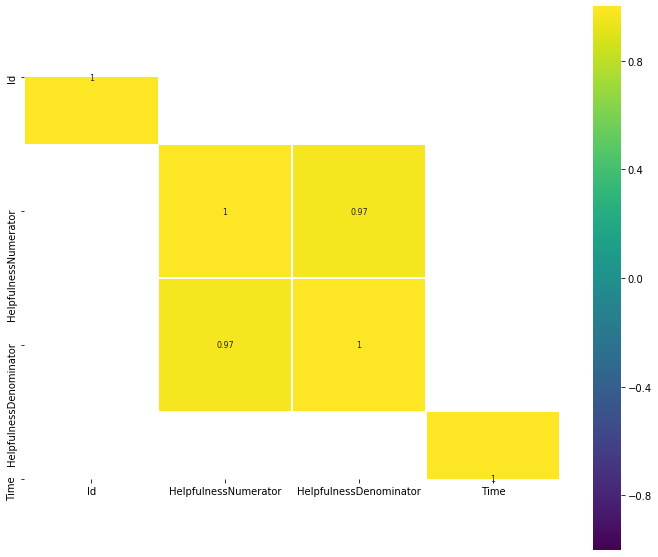

In [36]:
# exploring inter-correlation among numeric attributes.
corr = df_num.drop('Score', axis=1).corr() # We already examined Score correlations
plt.figure(figsize=(12, 10))

# here we finally plot a correlation matrix for our numeric attributes.
sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

In [37]:
# now we move onto our categorical (non numeric) attributes. 
df_not_num = original_df.select_dtypes(include = ['O'])
print('There is {} non numerical features including:\n{}'.format(len(df_not_num.columns), df_not_num.columns.tolist()))

There is 5 non numerical features including:
['ProductId', 'UserId', 'ProfileName', 'Summary', 'Text']


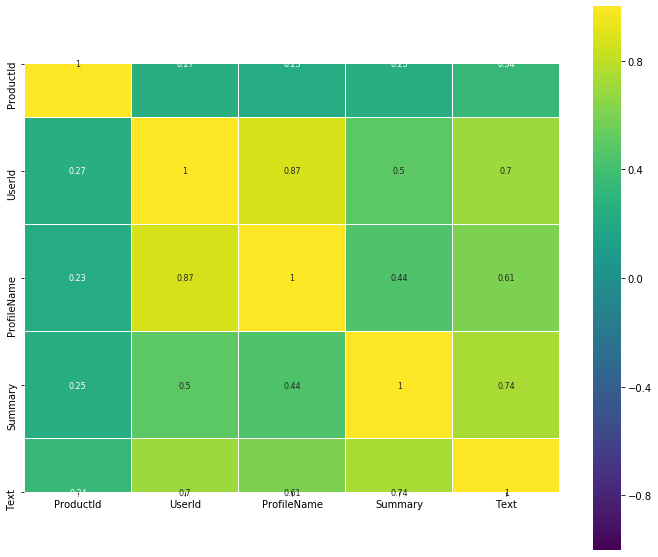

In [38]:
# Categorical attributes inter-correlation
plt.figure(figsize=(12, 10))
corr = df_not_num.apply(lambda x: x.factorize()[0]).corr()
sns.heatmap(corr, 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True)

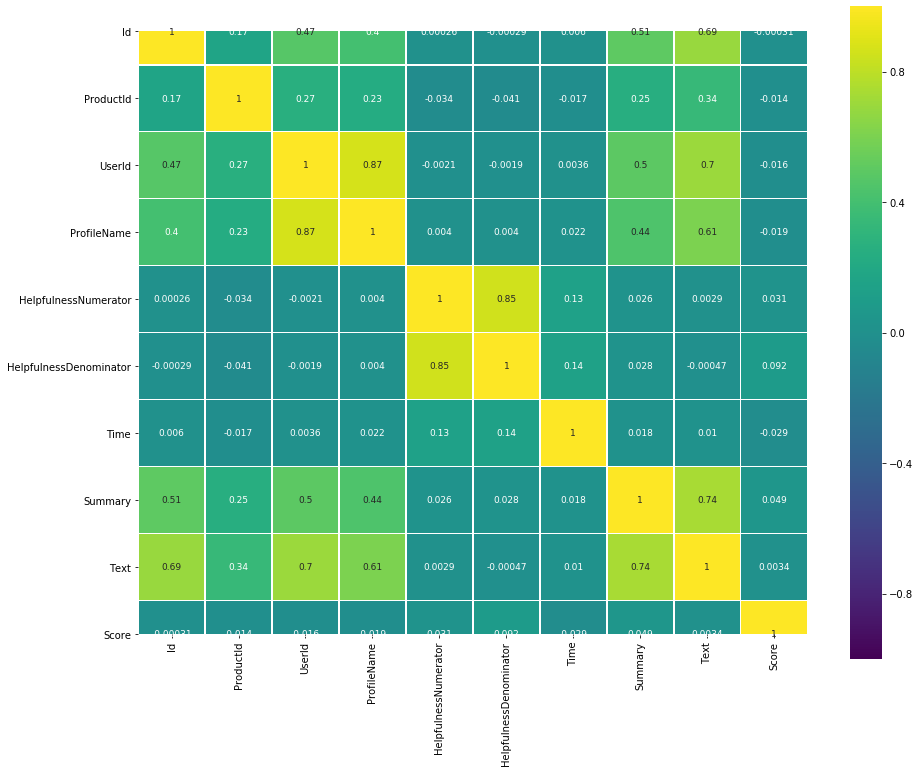

In [39]:
# we finally print a correlation matrix that includes our factorized categorical values as well as the numerical attributes.
plt.figure(figsize=(15, 12))
corr = original_df.apply(lambda x: x.factorize()[0]).corr()
sns.heatmap(corr, 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.5,
            annot=True, annot_kws={"size": 9}, square=True)

# 2-Text Processing and Normalization: (20%)
Thoroughly experiment with different text processing and normalization alternatives. Explain the
trade-off and benefits of using each and justify their effectiveness for the current data set. 

#### Extract Needed Columns

In [40]:
# Get rid of un needed columns

df_required_columns = neededColumnsOnly(original_df, ['ProductId','Score','Summary','Text'])

In [41]:
df_required_columns.head(10)

,ProductId,Summary,Text,Score
0,B0034EDLS2,Very Good,I received this product early from the seller!...,5
1,B001I7HJE4,"Organic, Kosher, Tasty Assortment of Premium T...",*****<br />Numi's Collection Assortment Melang...,5
2,B000LKTB90,"excellent gluten-free spaghetti: great taste, ...","I was very careful not to overcook this pasta,...",5
3,B001HXJPS2,Lindt is Lindt,Buying this multi-pack I was misled by the pic...,5
4,B006H34CUS,YUM!!!!!,These bars are so good! I loved them warmed up...,5
5,B004728MI4,Delicious,"I love these chips, I buy the 24 pack once a m...",5
6,B001BZ5EFE,Tastes great and it's organic!!,I'm a huge fan of eating cereal for breakfast....,5
7,B0001AVRQK,Poor taste,I was really disappointed with the Sorghum we ...,2
8,B005GV9RZC,Better than US Instant Coffee,A friend who has gone to Korea gave me a coupl...,3
9,B004FEN3GK,Hard not to like!,No need for plastic baggies or sloppy tin foil...,4


#### Remove Nulls

In [42]:
# Get list of columns containing null values

list_columns_with_nulls = columns_with_nulls(df_required_columns, 'ProductId')

In [43]:
list_columns_with_nulls

['Summary']

In [44]:
# Replace null values with empty string

df_without_nulls = remove_nulls(df_required_columns, list_columns_with_nulls)

In [45]:
df_without_nulls.head()

,ProductId,Summary,Text,Score
0,B0034EDLS2,Very Good,I received this product early from the seller!...,5
1,B001I7HJE4,"Organic, Kosher, Tasty Assortment of Premium T...",*****<br />Numi's Collection Assortment Melang...,5
2,B000LKTB90,"excellent gluten-free spaghetti: great taste, ...","I was very careful not to overcook this pasta,...",5
3,B001HXJPS2,Lindt is Lindt,Buying this multi-pack I was misled by the pic...,5
4,B006H34CUS,YUM!!!!!,These bars are so good! I loved them warmed up...,5


In [46]:
# double check if removed

columns_with_nulls(df_without_nulls, 'ProductId')

[]

#### Remove Html Tags

In [47]:
# Get list of columns containing html tags

list_columns_with_html = columns_with_html(df_without_nulls)

In [48]:
list_columns_with_html

['Text']

In [49]:
# example of html tag in text column

df_without_nulls.loc[1]['Text']

'*****<br />Numi\'s Collection Assortment Melange includes:<br />5 Herbal Teas (caffeine-free, also called "teasans"):<br />* Dry Desert Lime: Lime Herbal Teasan<br />* Fields of Gold: Lemongrass Herbal Teasan<br />* Red Mellow Bush: Rooibos Herbal Teasan<br />* Bushmen\'s Brew: Honeybush Herbal Teasan<br />* Simply Mint: Moroccan Mint<br /><br />2 Green Teas (lower in caffeine):<br />* Temple of Heaven: Gunpowder Green Tea<br />* Monkey King: Jasmine Green Tea<br /><br />2 Black Teas (contain caffeine):<br />* Chinese Breakfast: Yunnan Black Tea<br />* Smoky Tarry: Lapsang Souchong Black Tea<br /><br />This is a total of nine different teas, two tea bags of each one in each box. Numi teas are known for their high-quality, organic and kosher ingredients, and in my opinion, are some of the tastiest and best teas I have ever tried. They do not include artificial ingredients or flavorings.<br /><br />On the box, the manufacturer writes: "From mist-covered mountains to sun-drenched deserts

In [50]:
df_without_html = df_without_nulls.copy()

In [51]:
# Get rid of html tags 
df_without_html['Text'] = df_without_html['Text'].apply(remove_html_tags)

In [52]:
df_without_html.loc[1]['Text']

'***** Numi\'s Collection Assortment Melange includes: 5 Herbal Teas (caffeine-free, also called "teasans"): * Dry Desert Lime: Lime Herbal Teasan * Fields of Gold: Lemongrass Herbal Teasan * Red Mellow Bush: Rooibos Herbal Teasan * Bushmen\'s Brew: Honeybush Herbal Teasan * Simply Mint: Moroccan Mint 2 Green Teas (lower in caffeine): * Temple of Heaven: Gunpowder Green Tea * Monkey King: Jasmine Green Tea 2 Black Teas (contain caffeine): * Chinese Breakfast: Yunnan Black Tea * Smoky Tarry: Lapsang Souchong Black Tea This is a total of nine different teas, two tea bags of each one in each box. Numi teas are known for their high-quality, organic and kosher ingredients, and in my opinion, are some of the tastiest and best teas I have ever tried. They do not include artificial ingredients or flavorings. On the box, the manufacturer writes: "From mist-covered mountains to sun-drenched deserts to fertile fields, we proudly bring you our tea palette. The flavors range from smooth earthiness,

#### Merge Summary and Text in review column

In [53]:
# final dataframe preparation

final_df = merge_summary_text(df_without_html)

In [54]:
final_df.head(10)

,Score,review
0,5,Very Good I received this product early from t...
1,5,"Organic, Kosher, Tasty Assortment of Premium T..."
2,5,"excellent gluten-free spaghetti: great taste, ..."
3,5,Lindt is Lindt Buying this multi-pack I was mi...
4,5,YUM!!!!! These bars are so good! I loved them ...
5,5,"Delicious I love these chips, I buy the 24 pac..."
6,5,Tastes great and it's organic!! I'm a huge fan...
7,2,Poor taste I was really disappointed with the ...
8,3,Better than US Instant Coffee A friend who has...
9,4,Hard not to like! No need for plastic baggies ...


#####  Correct accented letters

In [55]:
#check if accent exist
text_html = final_df['review'].str.find('é')
text_html = text_html[text_html != -1]

In [56]:
text_html.head(10)

864       173
3467      371
4554     1236
4590     1494
7852       15
9339      123
10269     107
12255     112
14951    1547
15712      61
Name: review, dtype: int64

In [57]:
final_df['review'].iloc[15712] #nescafé  is found

"not my cup of coffee i bought this becuase i liked the nescafé packets of instant coffee that i got in my hotel room the last time i was in the dominican republic and i'll admit, i don't like coffee. but when i tried this stuff from dominican i was like omg this is a party in my mouth and i'm drinking it black!!! so i bought this nescafé canister hoping it would be the same. well it wasn't. this stuff has nothing to recommend it. it's worse than most coffees i've tried."

In [58]:
#remove accents
final_df['review'] = final_df['review'].apply(correct_accent)

In [59]:
#double check if removed
final_df['review'].iloc[15712]

"not my cup of coffee i bought this becuase i liked the nescafe packets of instant coffee that i got in my hotel room the last time i was in the dominican republic and i'll admit, i don't like coffee. but when i tried this stuff from dominican i was like omg this is a party in my mouth and i'm drinking it black!!! so i bought this nescafe canister hoping it would be the same. well it wasn't. this stuff has nothing to recommend it. it's worse than most coffees i've tried."

##### Remove Punctuations

In [60]:
#remove punctuations
final_df['review'] = final_df['review'].apply(remove_punctuations)

In [61]:
final_df.iloc[1]["review"]

"Organic  Kosher  Tasty Assortment of Premium Teas   Teasans       Numi's Collection Assortment Melange includes  5 Herbal Teas  caffeine free  also called  teasans      Dry Desert Lime  Lime Herbal Teasan   Fields of Gold  Lemongrass Herbal Teasan   Red Mellow Bush  Rooibos Herbal Teasan   Bushmen's Brew  Honeybush Herbal Teasan   Simply Mint  Moroccan Mint 2 Green Teas  lower in caffeine     Temple of Heaven  Gunpowder Green Tea   Monkey King  Jasmine Green Tea 2 Black Teas  contain caffeine     Chinese Breakfast  Yunnan Black Tea   Smoky Tarry  Lapsang Souchong Black Tea This is a total of nine different teas  two tea bags of each one in each box  Numi teas are known for their high quality  organic and kosher ingredients  and in my opinion  are some of the tastiest and best teas I have ever tried  They do not include artificial ingredients or flavorings  On the box  the manufacturer writes   From mist covered mountains to sun drenched deserts to fertile fields  we proudly bring you 

##### Expand Short Words

In [62]:
final_df['review'] = final_df['review'].apply(expand_words)

In [63]:
final_df.iloc[1]["review"]

"Organic  Kosher  Tasty Assortment of Premium Teas   Teasans       Numi's Collection Assortment Melange includes  5 Herbal Teas  caffeine free  also called  teasans      Dry Desert Lime  Lime Herbal Teasan   Fields of Gold  Lemongrass Herbal Teasan   Red Mellow Bush  Rooibos Herbal Teasan   Bushmen's Brew  Honeybush Herbal Teasan   Simply Mint  Moroccan Mint 2 Green Teas  lower in caffeine     Temple of Heaven  Gunpowder Green Tea   Monkey King  Jasmine Green Tea 2 Black Teas  contain caffeine     Chinese Breakfast  Yunnan Black Tea   Smoky Tarry  Lapsang Souchong Black Tea This is a total of nine different teas  two tea bags of each one in each box  Numi teas are known for their high quality  organic and kosher ingredients  and in my opinion  are some of the tastiest and best teas I have ever tried  They do not include artificial ingredients or flavorings  On the box  the manufacturer writes   From mist covered mountains to sun drenched deserts to fertile fields  we proudly bring you 

##### Remove remaining apostrophe

In [64]:
final_df['review'] = final_df['review'].apply(remove_apostrophe)

In [65]:
final_df.iloc[1]["review"]

'Organic  Kosher  Tasty Assortment of Premium Teas   Teasans       Numi s Collection Assortment Melange includes  5 Herbal Teas  caffeine free  also called  teasans      Dry Desert Lime  Lime Herbal Teasan   Fields of Gold  Lemongrass Herbal Teasan   Red Mellow Bush  Rooibos Herbal Teasan   Bushmen s Brew  Honeybush Herbal Teasan   Simply Mint  Moroccan Mint 2 Green Teas  lower in caffeine     Temple of Heaven  Gunpowder Green Tea   Monkey King  Jasmine Green Tea 2 Black Teas  contain caffeine     Chinese Breakfast  Yunnan Black Tea   Smoky Tarry  Lapsang Souchong Black Tea This is a total of nine different teas  two tea bags of each one in each box  Numi teas are known for their high quality  organic and kosher ingredients  and in my opinion  are some of the tastiest and best teas I have ever tried  They do not include artificial ingredients or flavorings  On the box  the manufacturer writes   From mist covered mountains to sun drenched deserts to fertile fields  we proudly bring you 

#### Remove Extra Spaces

In [66]:
final_df['review'] = final_df['review'].apply(remove_extra_space)

In [67]:
final_df.iloc[1]["review"]

'Organic Kosher Tasty Assortment of Premium Teas Teasans Numi s Collection Assortment Melange includes 5 Herbal Teas caffeine free also called teasans Dry Desert Lime Lime Herbal Teasan Fields of Gold Lemongrass Herbal Teasan Red Mellow Bush Rooibos Herbal Teasan Bushmen s Brew Honeybush Herbal Teasan Simply Mint Moroccan Mint 2 Green Teas lower in caffeine Temple of Heaven Gunpowder Green Tea Monkey King Jasmine Green Tea 2 Black Teas contain caffeine Chinese Breakfast Yunnan Black Tea Smoky Tarry Lapsang Souchong Black Tea This is a total of nine different teas two tea bags of each one in each box Numi teas are known for their high quality organic and kosher ingredients and in my opinion are some of the tastiest and best teas I have ever tried They do not include artificial ingredients or flavorings On the box the manufacturer writes From mist covered mountains to sun drenched deserts to fertile fields we proudly bring you our tea palette The flavors range from smooth earthiness and 

In [68]:
final_df.head(10)

,Score,review
0,5,Very Good I received this product early from t...
1,5,Organic Kosher Tasty Assortment of Premium Tea...
2,5,excellent gluten free spaghetti great taste gr...
3,5,Lindt is Lindt Buying this multi pack I was mi...
4,5,YUM These bars are so good I loved them warmed...
5,5,Delicious I love these chips I buy the 24 pack...
6,5,Tastes great and it is organic I am a huge fan...
7,2,Poor taste I was really disappointed with the ...
8,3,Better than US Instant Coffee A friend who has...
9,4,Hard not to like No need for plastic baggies o...


####  transform to lower case

In [69]:
final_df['review'] = final_df['review'].apply(toLower)

In [70]:
final_df.iloc[1]["review"]

'organic kosher tasty assortment of premium teas teasans numi s collection assortment melange includes 5 herbal teas caffeine free also called teasans dry desert lime lime herbal teasan fields of gold lemongrass herbal teasan red mellow bush rooibos herbal teasan bushmen s brew honeybush herbal teasan simply mint moroccan mint 2 green teas lower in caffeine temple of heaven gunpowder green tea monkey king jasmine green tea 2 black teas contain caffeine chinese breakfast yunnan black tea smoky tarry lapsang souchong black tea this is a total of nine different teas two tea bags of each one in each box numi teas are known for their high quality organic and kosher ingredients and in my opinion are some of the tastiest and best teas i have ever tried they do not include artificial ingredients or flavorings on the box the manufacturer writes from mist covered mountains to sun drenched deserts to fertile fields we proudly bring you our tea palette the flavors range from smooth earthiness and 

#### remove stop words

In [71]:
final_df['review'] = final_df['review'].apply(remove_stop_words)

In [72]:
final_df.iloc[1]["review"]

'organic kosher tasty assortment premium teas teasans numi collection assortment melange includes 5 herbal teas caffeine free also called teasans dry desert lime lime herbal teasan fields gold lemongrass herbal teasan red mellow bush rooibos herbal teasan bushmen brew honeybush herbal teasan simply mint moroccan mint 2 green teas lower caffeine temple heaven gunpowder green tea monkey king jasmine green tea 2 black teas contain caffeine chinese breakfast yunnan black tea smoky tarry lapsang souchong black tea total nine different teas two tea bags one box numi teas known high quality organic kosher ingredients opinion tastiest best teas ever tried not include artificial ingredients flavorings box manufacturer writes mist covered mountains sun drenched deserts fertile fields proudly bring tea palette flavors range smooth earthiness light floral scents refreshingly sweet sour notes share recollection ancient one tamed fire water coexist harmoniously steeped gifts nature since distant pas

####  remove extra spaces again

In [73]:
final_df['review'] = final_df['review'].apply(remove_extra_space)

In [74]:
final_df.head(10)

,Score,review
0,5,very good received product early seller tastey...
1,5,organic kosher tasty assortment premium teas t...
2,5,excellent gluten free spaghetti great taste gr...
3,5,lindt lindt buying multi pack misled picture w...
4,5,yum bars good loved warmed definitely think gr...
5,5,delicious love chips buy 24 pack month bags ri...
6,5,tastes great organic huge fan eating cereal br...
7,2,poor taste really disappointed sorghum purchas...
8,3,better us instant coffee friend gone korea gav...
9,4,hard not like no need plastic baggies sloppy t...


## 1.3 Cleaned data Explore and Visualize

#### Visualize score count

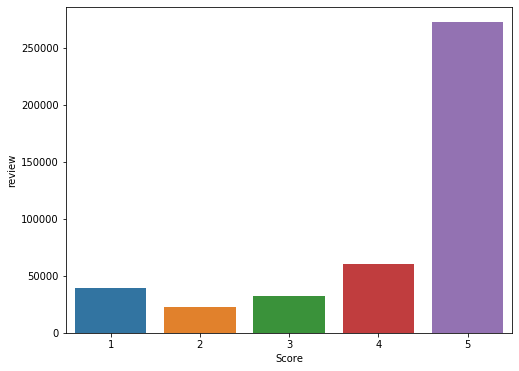

In [75]:
visualize_score_count(final_df)

####  Describe Score Data

In [99]:
#Groupby Score and describe()
final_df.groupby('Score').describe()

review                                                                
        count  unique                                                top freq
Score                                                                        
1       28452   28452  1 mile ha not charge 100 feet product poor per...    1
2       16278   16278  way sweet calories regular coke even though sa...    1
3       23276   23276  ok not greatest nutella and would give 3 stars...    1
4       43837   43837  great tase dry taste good spiced well really d...    1
5      196968  196968  best k cups keep short simple best k cups had ...    1

####  Analyze finding

#### we found that not all are unique. so we investigate further for uniqness

In [77]:
final_df.groupby('review').agg('count')

,Score
review,
0 calories 0 fat 0 carbs 0 sugar sweeeet torani sugar free vanilla flavor syrup nice way add little variety coffee without run starbuck sugar free vanilla latte mentioned title no calories fats carbs sugars taste sweet vanillery use anything want add little variety flavor like pellegrino makes nice vanilla soda coffee found not add anything else syrup good enough tasty enough use whenever get sweet tooth get past craving something calories involved sweetened splenda not used using sugar substitutes may not like little bit taste leaves ingrediants listed water vanilla extract natural flavors potassium sorbate sodium benzoate 5 mg sodium listed label citric acid xanthan gum sucralose splenda acesulfame potassium bargain 750 ml sold paid almost much 375ml local grocery store probably use two tablespoons per drink less get money worth add anything want hot chocolate iced tea etc maybe holiday coming would nice change beverages well also sold sugar added several flavors without sugar click products torani top page cheers laurie,1
0 calories awesome prepared awful smell opening bag based reviews water smells like fish not big deal rinsed noodles 2 minutes hot water placed boiling water another 2 3 minutes mixed noodles sauce popular spicy szechuan style vegetable chicken weight loss frozen food softened microwave cut sauce noodles packaged put noodles sauce fridge 22 hours eating based suggestion reviews texture strange no food product market 100 compare rubbery somewhat hard break teeth chew marinating noodles not help still flavorless not matter much sauce spicy enough mask fact noodles no flavor suggest noodles anyone trying lose weight cut carbs not something would want eat otherwise,1
0 calories passable taste watching calorie intake love product no calories huge plus knew taste would not big full calorie full fat peanut butters tried pb j tasted fine local store would carry product instead order online,1
0 good made panna cotta one main ingredients gelatin came great would recommend even though going try products,1
0 net carbs delicious bought 8 oz cocoa local co op impressed every brand cocoa bought added sugar cocoa not 2 carbs 2 grams fiber per tablespoon strong genuine chocolate flavor use make chocolate mousse hot cocoa add chocolate flavor baked goods not able find stores since relocated pleased see amazon highly recommended information available company site http www equalexchange coop cocoa,1
...,...
zz plant awesome house plant everyone must one interesting look fast growing easy take care of,1
zzfantastic coffee luxury experiencing blue mountain kona little farm beans obscure travels friends coffee ranks right waited review drinking month 4 weeks of daily brewing still takes great seems like low acidity unique flavor not lend normal categories cherries chocolate etc price point not bother 30 dollar delivery charge seems range good,1
zzzzzzzzz product amazing tried dream water nuero sleep dream water worked time no matter would knocked half hour,2


#### visualize one of the duplicate data

In [78]:
t = final_df['review'].str.find('I only used two maybe three tea bags and got pregnan')
t = t[t != -1]

In [79]:
t

Series([], Name: review, dtype: int64)

In [80]:
final_df.loc[43935]['review']

'i used two maybe three tea bags got pregnant not drink pregnancy not bad taste not big tea fan either'

In [81]:
final_df.loc[187578]['review']

'i used two maybe three tea bags got pregnant not drink pregnancy not bad taste not big tea fan either'

In [82]:
final_df.loc[306678]['review']

'i used two maybe three tea bags got pregnant not drink pregnancy not bad taste not big tea fan either'

#### check initial row count

In [83]:
final_df.count()

Score     426340
review    426340
dtype: int64

####  Remove Duplicates

In [84]:
final_df.drop_duplicates(keep="first",inplace=True)

#### check new row count

In [85]:
final_df.count()

Score     308811
review    308811
dtype: int64

In [86]:
final_df.groupby('Score').describe()

review                                                                
        count  unique                                                top freq
Score                                                                        
1       28452   28452  1 mile ha not charge 100 feet product poor per...    1
2       16278   16278  way sweet calories regular coke even though sa...    1
3       23276   23276  ok not greatest nutella and would give 3 stars...    1
4       43837   43837  great tase dry taste good spiced well really d...    1
5      196968  196968  best k cups keep short simple best k cups had ...    1

In [87]:
final_df.head(10)

,Score,review
0,5,very good received product early seller tastey...
1,5,organic kosher tasty assortment premium teas t...
2,5,excellent gluten free spaghetti great taste gr...
3,5,lindt lindt buying multi pack misled picture w...
4,5,yum bars good loved warmed definitely think gr...
5,5,delicious love chips buy 24 pack month bags ri...
6,5,tastes great organic huge fan eating cereal br...
7,2,poor taste really disappointed sorghum purchas...
8,3,better us instant coffee friend gone korea gav...
9,4,hard not like no need plastic baggies sloppy t...


In [88]:
final_df.iloc[124]['review']

'good not amazing sauce not mild expecting something much hotter literally pour food without difficulty taste good extremely sweet not go lot foods someone gave second bottle gift certainly use would not buy second bottle either like sweet sauces not looking scorching addition food good choice'

# 2-Text Processing and Normalization: (20%)
Thoroughly experiment with different text processing and normalization alternatives. Explain the
trade-off and benefits of using each and justify their effectiveness for the current data set. 

####  Extract part of final data

In [89]:
final_df_sub = final_df.head(10).copy()

In [90]:
final_df_sub.head(10)

,Score,review
0,5,very good received product early seller tastey...
1,5,organic kosher tasty assortment premium teas t...
2,5,excellent gluten free spaghetti great taste gr...
3,5,lindt lindt buying multi pack misled picture w...
4,5,yum bars good loved warmed definitely think gr...
5,5,delicious love chips buy 24 pack month bags ri...
6,5,tastes great organic huge fan eating cereal br...
7,2,poor taste really disappointed sorghum purchas...
8,3,better us instant coffee friend gone korea gav...
9,4,hard not like no need plastic baggies sloppy t...


#### Tokenize Data

In [91]:
final_df_sub['token'] = final_df_sub['review'].apply(tokeniz)

In [92]:
final_df_sub.head(10)

,Score,review,token
0,5,very good received product early seller tastey...,"[very, good, received, product, early, seller,..."
1,5,organic kosher tasty assortment premium teas t...,"[organic, kosher, tasty, assortment, premium, ..."
2,5,excellent gluten free spaghetti great taste gr...,"[excellent, gluten, free, spaghetti, great, ta..."
3,5,lindt lindt buying multi pack misled picture w...,"[lindt, lindt, buying, multi, pack, misled, pi..."
4,5,yum bars good loved warmed definitely think gr...,"[yum, bars, good, loved, warmed, definitely, t..."
5,5,delicious love chips buy 24 pack month bags ri...,"[delicious, love, chips, buy, 24, pack, month,..."
6,5,tastes great organic huge fan eating cereal br...,"[tastes, great, organic, huge, fan, eating, ce..."
7,2,poor taste really disappointed sorghum purchas...,"[poor, taste, really, disappointed, sorghum, p..."
8,3,better us instant coffee friend gone korea gav...,"[better, us, instant, coffee, friend, gone, ko..."
9,4,hard not like no need plastic baggies sloppy t...,"[hard, not, like, no, need, plastic, baggies, ..."


#### Stemming Data

In [93]:
# Stem data and calculate time needed for that
start_time = time.time()
final_df_sub['stem'] = final_df_sub['review'].apply(stemm)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.018007993698120117 seconds ---


In [94]:
final_df_sub.head(10)

,Score,review,token,stem
0,5,very good received product early seller tastey...,"[very, good, received, product, early, seller,...",veri good receiv product earli seller tastey g...
1,5,organic kosher tasty assortment premium teas t...,"[organic, kosher, tasty, assortment, premium, ...",organ kosher tasti assort premium tea teasan n...
2,5,excellent gluten free spaghetti great taste gr...,"[excellent, gluten, free, spaghetti, great, ta...",excel gluten free spaghetti great tast great s...
3,5,lindt lindt buying multi pack misled picture w...,"[lindt, lindt, buying, multi, pack, misled, pi...",lindt lindt buy multi pack misl pictur whole h...
4,5,yum bars good loved warmed definitely think gr...,"[yum, bars, good, loved, warmed, definitely, t...",yum bar good love warm definit think great sna...
5,5,delicious love chips buy 24 pack month bags ri...,"[delicious, love, chips, buy, 24, pack, month,...",delici love chip buy 24 pack month bag right s...
6,5,tastes great organic huge fan eating cereal br...,"[tastes, great, organic, huge, fan, eating, ce...",tast great organ huge fan eat cereal breakfast...
7,2,poor taste really disappointed sorghum purchas...,"[poor, taste, really, disappointed, sorghum, p...",poor tast realli disappoint sorghum purchas us...
8,3,better us instant coffee friend gone korea gav...,"[better, us, instant, coffee, friend, gone, ko...",better us instant coffe friend gone korea gave...
9,4,hard not like no need plastic baggies sloppy t...,"[hard, not, like, no, need, plastic, baggies, ...",hard not like no need plastic baggi sloppi tin...


####  Lemmatizing Data

In [95]:
# Lemmatize data and calculate time needed for that
start_time = time.time()
final_df_sub['lemm'] = final_df_sub['review'].apply(lemm)
print("--- %s seconds ---" % (time.time() - start_time))

--- 2.10518741607666 seconds ---


In [96]:
final_df_sub.head(10)

,Score,review,token,stem,lemm
0,5,very good received product early seller tastey...,"[very, good, received, product, early, seller,...",veri good receiv product earli seller tastey g...,very good received product early seller tastey...
1,5,organic kosher tasty assortment premium teas t...,"[organic, kosher, tasty, assortment, premium, ...",organ kosher tasti assort premium tea teasan n...,organic kosher tasty assortment premium tea te...
2,5,excellent gluten free spaghetti great taste gr...,"[excellent, gluten, free, spaghetti, great, ta...",excel gluten free spaghetti great tast great s...,excellent gluten free spaghetti great taste gr...
3,5,lindt lindt buying multi pack misled picture w...,"[lindt, lindt, buying, multi, pack, misled, pi...",lindt lindt buy multi pack misl pictur whole h...,lindt lindt buying multi pack misled picture w...
4,5,yum bars good loved warmed definitely think gr...,"[yum, bars, good, loved, warmed, definitely, t...",yum bar good love warm definit think great sna...,yum bar good loved warmed definitely think gre...
5,5,delicious love chips buy 24 pack month bags ri...,"[delicious, love, chips, buy, 24, pack, month,...",delici love chip buy 24 pack month bag right s...,delicious love chip buy 24 pack month bag righ...
6,5,tastes great organic huge fan eating cereal br...,"[tastes, great, organic, huge, fan, eating, ce...",tast great organ huge fan eat cereal breakfast...,taste great organic huge fan eating cereal bre...
7,2,poor taste really disappointed sorghum purchas...,"[poor, taste, really, disappointed, sorghum, p...",poor tast realli disappoint sorghum purchas us...,poor taste really disappointed sorghum purchas...
8,3,better us instant coffee friend gone korea gav...,"[better, us, instant, coffee, friend, gone, ko...",better us instant coffe friend gone korea gave...,better u instant coffee friend gone korea gave...
9,4,hard not like no need plastic baggies sloppy t...,"[hard, not, like, no, need, plastic, baggies, ...",hard not like no need plastic baggi sloppi tin...,hard not like no need plastic baggies sloppy t...


#### Lemmatizing Data using spacy

In [109]:
# Lemmatize data and calculate time needed for that
start_time = time.time()
final_df_sub['spacy_lemm'] = final_df_sub['review'].apply(spacy_lemm)
print("--- %s seconds ---" % (time.time() - start_time))

--- 6.236131191253662 seconds ---


In [110]:
final_df_sub.head(10)

,Score,review,token,stem,lemm,spacy_lemm
0,5,very good received product early seller tastey...,"[very, good, received, product, early, seller,...",veri good receiv product earli seller tastey g...,very good received product early seller tastey...,very good receive product early seller tastey ...
1,5,organic kosher tasty assortment premium teas t...,"[organic, kosher, tasty, assortment, premium, ...",organ kosher tasti assort premium tea teasan n...,organic kosher tasty assortment premium tea te...,organic kosher tasty assortment premium tea te...
2,5,excellent gluten free spaghetti great taste gr...,"[excellent, gluten, free, spaghetti, great, ta...",excel gluten free spaghetti great tast great s...,excellent gluten free spaghetti great taste gr...,excellent gluten free spaghetti great taste gr...
3,5,lindt lindt buying multi pack misled picture w...,"[lindt, lindt, buying, multi, pack, misled, pi...",lindt lindt buy multi pack misl pictur whole h...,lindt lindt buying multi pack misled picture w...,lindt lindt buying multi pack mislead picture ...
4,5,yum bars good loved warmed definitely think gr...,"[yum, bars, good, loved, warmed, definitely, t...",yum bar good love warm definit think great sna...,yum bar good loved warmed definitely think gre...,yum bar good love warmed definitely think grea...
5,5,delicious love chips buy 24 pack month bags ri...,"[delicious, love, chips, buy, 24, pack, month,...",delici love chip buy 24 pack month bag right s...,delicious love chip buy 24 pack month bag righ...,delicious love chip buy 24 pack month bag righ...
6,5,tastes great organic huge fan eating cereal br...,"[tastes, great, organic, huge, fan, eating, ce...",tast great organ huge fan eat cereal breakfast...,taste great organic huge fan eating cereal bre...,taste great organic huge fan eat cereal breakf...
7,2,poor taste really disappointed sorghum purchas...,"[poor, taste, really, disappointed, sorghum, p...",poor tast realli disappoint sorghum purchas us...,poor taste really disappointed sorghum purchas...,poor taste really disappointed sorghum purchas...
8,3,better us instant coffee friend gone korea gav...,"[better, us, instant, coffee, friend, gone, ko...",better us instant coffe friend gone korea gave...,better u instant coffee friend gone korea gave...,well us instant coffee friend go korea give co...
9,4,hard not like no need plastic baggies sloppy t...,"[hard, not, like, no, need, plastic, baggies, ...",hard not like no need plastic baggi sloppi tin...,hard not like no need plastic baggies sloppy t...,hard not like no need plastic baggie sloppy ti...


#### Compare Results

In [111]:
final_df_sub['stem'].iloc[0]

'veri good receiv product earli seller tastey great mid day snack share glutten free friend order product soon'

In [112]:
final_df_sub['lemm'].iloc[0]

'very good received product early seller tastey great mid day snack shared glutten free friend ordering product soon'

In [113]:
final_df_sub['review'].iloc[0]

'very good received product early seller tastey great mid day snack shared glutten free friends ordering product soon'

In [114]:
final_df_sub['spacy_lemm'].iloc[0]

'very good receive product early seller tastey great mid day snack share glutten free friend order product soon'

# 3. Vector space Model and feature representation: (20%)
Experiment with different representation techniques. Document your findings and make
conclusions. Show how choosing n-gram features can influence your results

#### Count Vector

In [115]:
xTrain, y_Train, count_vect, feature_names, count_vectDF = VCM("count", final_df_sub, "stem", "Score")

In [116]:
count_vectDF.head(10)

,24,50,absolut,al,also,amazon,amount,ancient,anoth,artifici,...,wheat,whole,wife,wonder,would,wrapper,write,year,yum,yunnan
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,1,0,1,...,0,0,0,2,0,0,1,0,0,1
2,0,0,1,2,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [117]:
#visualize important features 
count_vectDF.mean(axis=0).sort_values()

24        0.1
past      0.1
par       0.1
palett    0.1
packag    0.1
         ... 
free      0.7
tast      0.9
great     0.9
not       1.1
tea       1.6
Length: 346, dtype: float64

#### TFIDF Vector

In [118]:
xTrain2, y_Train2, tfidf_vect, feature_names2, tfidf_vectDF = VCM("tfidf", final_df_sub, "stem", "Score")

In [119]:
tfidf_vectDF.head(10)

,24,50,absolut,al,also,amazon,amount,ancient,anoth,artifici,...,wheat,whole,wife,wonder,would,wrapper,write,year,yum,yunnan
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000
1,0.000000,0.000000,0.000000,0.000000,0.035696,0.000000,0.000000,0.04199,0.000000,0.04199,...,0.000000,0.000000,0.000000,0.083981,0.000000,0.000000,0.04199,0.000000,0.00000,0.04199
2,0.000000,0.000000,0.077484,0.154968,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,...,0.077484,0.000000,0.077484,0.000000,0.000000,0.000000,0.00000,0.065868,0.00000,0.00000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.193097,0.00000,...,0.000000,0.193097,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.32186,0.00000
5,0.207422,0.000000,0.000000,0.000000,0.000000,0.000000,0.207422,0.00000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.118819,0.000000,0.00000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000
7,0.000000,0.213756,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.181712,0.00000,0.00000
8,0.000000,0.000000,0.000000,0.000000,0.094112,0.000000,0.000000,0.00000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.110709,0.000000,0.00000,0.000000,0.00000,0.00000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.171816,0.00000,0.000000,0.00000,0.00000


In [120]:
#visualize important features 
tfidf_vectDF.mean(axis=0).sort_values()

lower        0.004199
honeybush    0.004199
infus        0.004199
jasmin       0.004199
king         0.004199
               ...   
tea          0.067184
great        0.077192
good         0.077513
product      0.080630
tast         0.081357
Length: 346, dtype: float64

### <font color='red'> here we can note that some features although are important, but they are irrelevent in 1 gram and may need bi gram to have good meaning example: taste it can represent either good or bad taste </FONT>

#### Count Vector WITH BIGRAM

In [121]:
xTrain_ngram_2, y_Train_ngram_2, count_vect_ngram_2, feature_names_ngram_2, count_vectDF_ngram_2 = VCM("count", final_df_sub, "stem", "Score",2,2)

In [122]:
count_vectDF_ngram_2.head(10)

,24 pack,50 year,absolut perfect,al dent,also call,also thought,amazon carri,amount flavor,ancient one,anoth proof,...,wife italian,wonder assort,wonder infus,would prefer,wrapper honey,write mist,year old,year previous,yum bar,yunnan black
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,1,0,...,0,1,1,0,0,1,0,0,0,1
2,0,0,1,2,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [123]:
count_vectDF_ngram_2.mean(axis=0).sort_values()

24 pack            0.1
proudli bring      0.1
proof import       0.1
pronounc could     0.1
product tremend    0.1
                  ... 
black tea          0.3
green tea          0.3
tast great         0.3
herbal teasan      0.4
gluten free        0.4
Length: 516, dtype: float64

### <FONT COLOR="RED"> here we can see the combination of taste with other word how it has a clear meaning </FONT>

# 4- Model training, selection and hyperparameter tuning and evaluation:(20%)
You should at least experiment with 3 models and show how you can optimize model
parameters using cross validation. For each model discuss your choices of text processing,
representation and features from steps 1-3. 

In [124]:
# Imports and Functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string,lxml,bs4,nltk
from nltk.stem import PorterStemmer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Normalizer
import unicodedata
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from warnings import simplefilter

def dataframe_optimzer(dataframe):
    dataframe.Summary.fillna('', inplace=True)
    dataframe.Text.fillna('', inplace=True)
    dataframe.drop(['Id','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Time','ProductId'],axis=1,inplace=True)
    #Concatinating TEXT and Summary features as per the DR. example. Which is OK as I didnt find obvoius correlation
    dataframe['text']=dataframe['Summary']+' '+dataframe['Text'] 
    dataframe.drop(['Summary','Text'],axis=1,inplace=True)
    #dataframe['length']=dataframe['text'].str.len() 
    return dataframe

def tokenizer(text):
    no_html = bs4.BeautifulSoup(text,'lxml').get_text()
    no_punctuation = [char for char in no_html if char not in string.punctuation]
    no_punctuation = ''.join(no_punctuation)
    return no_punctuation

def stemmer(text):
    review = [nltkstemmer.stem(word) for word in text.split()]
    review = ' '.join(review) 
    return review

def lemmatizer(text):
    review = [nltklem.lemmatize(word,'v') for word in text.lower().split()]
    review = ' '.join(review)
    #print(review)
    return review

def classification_report_final (model): 
    y_pred_final = model.predict(df_test_data['text'])
    score_final =accuracy_score(df_test_labels,y_pred_final)
    print('Model score on unseen data',score_final)
    print (classification_report(df_test_labels,y_pred_final))

def dataloading():
    print('Loading reviews...',end='')
    df = pd.read_csv('train.csv')
    print('[ok]')
    print('Loaded {:,} reviews' .format(len(df)))
    
    df=df.head(1000)  # <--- Dataset limiter ia here, Can change
    
    print('applying dataframe optimizer...',end='')
    df = dataframe_optimzer(df)
    print('[OK]')

    print('applying dataframe tokenizer...',end='')
    df['text'].apply(tokenizer)
    print('[OK]')
    return df


nltk.download('wordnet')
nltklem = WordNetLemmatizer()
nltkstemmer = PorterStemmer()
simplefilter(action='ignore', category=Warning)


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tamers\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [125]:
df=dataloading()
#Loading test Data
df_test_data = dataframe_optimzer(pd.read_csv("test.csv"))
df_test_labels = pd.read_csv("labels.csv",usecols=['Score'])

Loading reviews...[ok]
Loaded 426,340 reviews
applying dataframe optimizer...[OK]
applying dataframe tokenizer...[OK]


# <font color='red'>REMOVE BELOW CELL BEFORE FINAL RUN</font>

In [126]:
final_df = final_df.head(1000) # ----> REMOVE BEFORE FINAL RUN

In [127]:
df_label = final_df['Score'].copy()
df_data = final_df['review'].copy()

In [128]:
 X_train, X_test, y_train, y_test = train_test_split(df_data, df_label, test_size=0.25, random_state=42)

In [129]:
estimators = [LogisticRegression,MultinomialNB,SGDClassifier]

In [130]:
def create_pipeline(estimator):
    
    pipeline_steps = [
        
        ('cv',CountVectorizer()),
        ('tfidf',TfidfTransformer()),
        ('classifier',estimator)
    ]
    
    return Pipeline(pipeline_steps)

In [131]:
#  parameters for Grid Search (CV and TfIdf) - BASE 
param_grid= {}

#Parameters for CountVectorizer
param_grid.update({})
param_grid.update({})
#param_grid.update({})
param_grid.update({})
#Parameters of TFIDF
param_grid.update({})
# Parameters for LR
param_grid_LR = {}
param_grid_LR = {}
param_grid_LR.update(param_grid)
# Parameters for MN
param_grid_MN = {}
param_grid_MN = {}
param_grid_MN.update(param_grid)
#Parameters for SGD here
param_grid_SG={}
param_grid_SG.update(param_grid)


In [132]:
estimators = {
    LogisticRegression : param_grid_LR,
    MultinomialNB : param_grid_MN,
    SGDClassifier : param_grid_SG
}

In [134]:
for estimator,search_param in estimators.items():
    scores=[]
    model = create_pipeline(estimator())
    search=GridSearchCV(model,search_param,n_jobs=-1)
    search.fit(X_train,y_train)
    y_pred = search.predict(X_test)
    score=accuracy_score(y_test,y_pred)
    scores.append(score)
    print(estimator.__name__,'scored',score)
    print("Best parameter (CV score=%0.3f):" % search.best_score_)
    print(search.best_params_)
    print (classification_report(y_test,y_pred))
    print('\n')
    print('Cross validation with unseen test data')
    classification_report_final(search)

LogisticRegression scored 0.664
Best parameter (CV score=0.655):
{}
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        24
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00        21
           4       0.50      0.03      0.06        33
           5       0.67      1.00      0.80       165

    accuracy                           0.66       250
   macro avg       0.23      0.21      0.17       250
weighted avg       0.51      0.66      0.53       250



Cross validation with unseen test data
Model score on unseen data 0.6377274582377528
              precision    recall  f1-score   support

           1       0.00      0.00      0.00     13075
           2       0.00      0.00      0.00      7416
           3       0.00      0.00      0.00     10647
           4       0.50      0.00      0.00     20346
           5       0.64      1.00      0.78     90630

    accuracy                  

# 5-Topic Modelling of high and low ratings*: (15%)
Examine the five-star reviews and the one-star reviews separately. Categorize each review into
a set of topics (10-20 topics). Can you infer any particular observations regarding the topics
discussed in the high rated reviews vs. the low rated reviews? Document any other observations
you have gained with this analysis. You may use a smaller subset of the reviews to better
demonstrate your findings.

In [135]:
from sklearn.decomposition import LatentDirichletAllocation

import mglearn as mglearn

In [136]:
is_score_5 = final_df['Score']==5

In [137]:
df_score_5 = final_df[is_score_5]

In [138]:
df_score_5.head(10)

,Score,review
0,5,very good received product early seller tastey...
1,5,organic kosher tasty assortment premium teas t...
2,5,excellent gluten free spaghetti great taste gr...
3,5,lindt lindt buying multi pack misled picture w...
4,5,yum bars good loved warmed definitely think gr...
5,5,delicious love chips buy 24 pack month bags ri...
6,5,tastes great organic huge fan eating cereal br...
10,5,ryvita love product unhappy expiration date pr...
11,5,yummy son loves chocolate got birthday really ...
13,5,oven fry weakness good fried fish age cut frie...


In [139]:
is_score_1 = final_df['Score']==1

In [140]:
df_score_1 = final_df[is_score_1]

In [141]:
df_score_1.head(10)

,Score,review
18,1,plastic taste first coffee tried got keurig di...
31,1,dangerous doggies not buy large german shepher...
49,1,ugh fake food wanted sugar splurge chose short...
55,1,worst products ever chinese never brought prod...
56,1,enormous ripoff nearly twice expensive cost ne...
113,1,these treats make pooch sick cocker spaniel ab...
142,1,fooled years drinking penta water five years w...
153,1,hope like burnt friendly face mr redenbacher m...
173,1,warning contains menadione according manufactu...
176,1,oo long oo short usually not bother write revi...


In [142]:
df_score_5_sub = df_score_5.head(1000).copy()

In [143]:
xTrain_5, y_Train_5, count_vect_5, feature_names_5, count_vectDF_5 = VCM("count", df_score_5_sub, "review", "Score")

In [144]:
lda = LatentDirichletAllocation(n_components=20, learning_method="online",
                                max_iter=25, random_state=0)

In [145]:
document_topics_5 = lda.fit_transform(xTrain_5)

In [146]:
print("lda.components_.shape: {}".format(lda.components_.shape))

lda.components_.shape: (20, 5487)


In [147]:
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]

In [148]:
feature_names_5_5 = np.array(feature_names_5)

In [149]:
mglearn.tools.print_topics(topics=range(20), feature_names=feature_names_5_5,
                           sorting=sorting, topics_per_chunk=5, n_words=20)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
napa          good          not           flaxseed      old           
carl          chicken       great         shampoo       wellness      
ca            magnesium     like          health        check         
tea           china         good          mill          yr            
lemon         make          love          senseo        choice        
love          great         one           morning       realized      
great         diamond       taste         skin          bladder       
trip          almonds       product       units         holistic      
found         blue          flavor        length        approach      
get           product       get           milled        feast         
thought       quality       best          05            fancy         
echinacea     dog           use           hodgson       kibbles       
whatev

In [150]:
df_score_1_sub = df_score_1.head(1000).copy()

xTrain_1, y_Train_1, count_vect_1, feature_names_1, count_vectDF_1 = VCM("count", df_score_1_sub, "review", "Score")

lda = LatentDirichletAllocation(n_components=20, learning_method="batch",

                                max_iter=25, random_state=0)

document_topics_1 = lda.fit_transform(xTrain_1)

print("lda.components_.shape: {}".format(lda.components_.shape))

lda.components_.shape: (20, 6606)

sorting_1 = np.argsort(lda.components_, axis=1)[:, ::-1]

feature_names_1_1 = np.array(feature_names_1)



lda.components_.shape: (20, 1841)


In [151]:
mglearn.tools.print_topics(topics=range(20), feature_names=feature_names_1_1,
                           sorting=sorting_1, topics_per_chunk=5, n_words=20)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
product       not           pound         not           month         
not           water         weighed       like          save          
triscuit      product       shy           taste         item          
msg           one           disappointed  tastes        made          
new           like          figuring      buy           water         
original      could         feed          overpriced    not           
blend         ever          feedback      this          fine          
garlic        coffee        feeding       get           price         
discs         get           feel          sweet         like          
gevalia       made          feelings      tea           15            
several       china         feels         nutmeg        even          
bottom        tap           feet          bucks         money         
try   

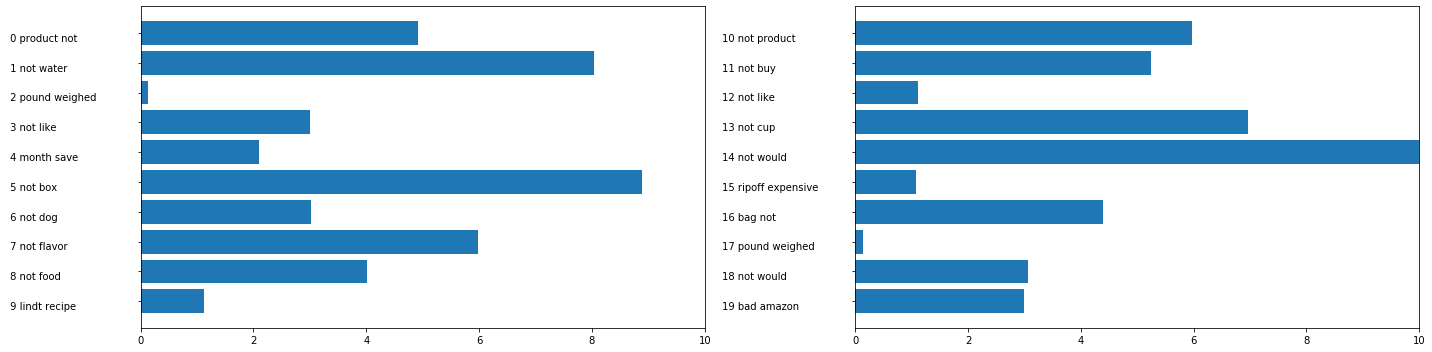

In [154]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
topic_names_1 = ["{:>2} ".format(i) + " ".join(words)
               for i, words in enumerate(feature_names_1_1[sorting_1[:, :2]])]
# two column bar chart:
for col in [0, 1]:
    start = col * 10
    end = (col + 1) * 10
    ax[col].barh(np.arange(10), np.sum(document_topics_1, axis=0)[start:end])
    ax[col].set_yticks(np.arange(10))
    ax[col].set_yticklabels(topic_names_1[start:end], ha="left", va="top")
    ax[col].invert_yaxis()
    ax[col].set_xlim(0, 10)
    yax = ax[col].get_yaxis()
    yax.set_tick_params(pad=130)
plt.tight_layout()

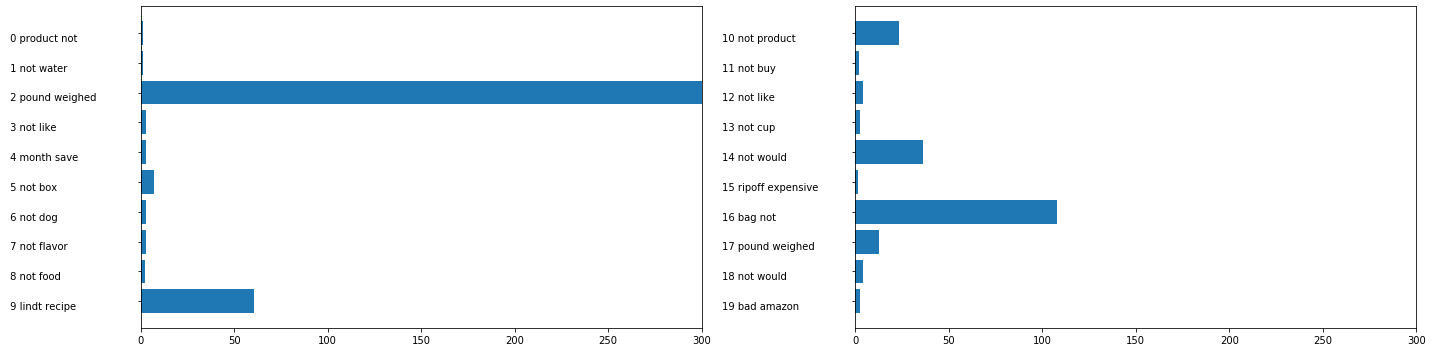

In [155]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
topic_names_5 = ["{:>2} ".format(i) + " ".join(words)
               for i, words in enumerate(feature_names_5_5[sorting[:, :2]])]
# two column bar chart:
for col in [0, 1]:
    start = col * 10
    end = (col + 1) * 10
    ax[col].barh(np.arange(10), np.sum(document_topics_5, axis=0)[start:end])
    ax[col].set_yticks(np.arange(10))
    ax[col].set_yticklabels(topic_names_1[start:end], ha="left", va="top")
    ax[col].invert_yaxis()
    ax[col].set_xlim(0, 300)
    yax = ax[col].get_yaxis()
    yax.set_tick_params(pad=130)
plt.tight_layout()

In [156]:
feature_names_5_5[sorting[:, :2]]

array([['napa', 'carl'],
       ['good', 'chicken'],
       ['not', 'great'],
       ['flaxseed', 'shampoo'],
       ['old', 'wellness'],
       ['ginger', 'black'],
       ['nom', 'vinegar'],
       ['lindt', 'baby'],
       ['pouch', 'twinnings'],
       ['not', 'better'],
       ['tea', 'teas'],
       ['bonsai', 'tuna'],
       ['blue', 'magnesium'],
       ['cytomax', 'agree'],
       ['coffee', 'not'],
       ['tham', 'cranberry'],
       ['not', 'food'],
       ['butter', 'peanut'],
       ['pasta', 'wheat'],
       ['tangerine', 'uncooked']], dtype='<U27')